In [1]:
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

from nldg.utils import generate_data_example_1, gen_data_isd, gen_data_maximin, gen_data_isd_v2
from nldg.maximin import MaximinRF, MaggingRF
from nldg.isd import IsdRF

import matplotlib.pyplot as plt

## Maximin

Inspired by the maximin effect estimator (see [1]), we modify the Random Forest to allow for robustness against distribution shifts.

In [28]:
#dtr, dts, _, _ = gen_data_isd(1000, 500,
#                              np.random.default_rng(42), 
#                              np.random.default_rng(42))
#dtr, dts = generate_data_example_1(42, False)
dtr, dts = gen_data_maximin(1000, 500,
                            np.random.default_rng(2), 
                            np.random.default_rng(2))
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [29]:
m_try = 2
rf = MaximinRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaximinRF(max_features=2)

In [30]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Ytr, Etr, Xts, wtype='inv')

In [31]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(52.1962091121941, -0.17409373080099821)

In [32]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(52.32942024542561, -0.1770901621330867)

## Magging

To aggregate the predictions from each environment, we need to compute the weights using magging (see [2]). Note that in [3] they use the same data for fitting the models and finding the weights through the optimization procedure. In the following, we instead further split the train data into train and validation data. The latter will be used to compute the weights.

In [2]:
#dtr, dts, _, _ = gen_data_isd(1000, 500,
#                              np.random.default_rng(42), 
#                              np.random.default_rng(42))
dtr, dts = gen_data_maximin(1000, 500,
                            np.random.default_rng(42), 
                            np.random.default_rng(42))
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [3]:
m_try = 4
mag_rf = MaggingRF(n_estimators=50, random_state=42, max_features=m_try)
wpreds = mag_rf.predict_magging(Xtr, Ytr, Etr, Xts)

In [4]:
mag_rf.weights_magging

array([0.16442269, 0.        , 0.06588179, 0.72098722, 0.0487083 ])

In [5]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)
preds = rf.predict(Xts)

In [7]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(103.14729724473074, -0.01822997106785862)

In [8]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(108.7181273623798, -0.07322303769237015)

## Invariant Subspace Decomposition

We modify the algorithm proposed in [4] to allow for nonlinear relationships between the features and the response.

In [2]:
dtr, dts, _, _ = gen_data_isd(1000, 500,
                              np.random.default_rng(42), 
                              np.random.default_rng(42))
#dtr, dts, _, _ = gen_data_isd_v2(1000, 500,
#                                 np.random.default_rng(42), 
#                                 np.random.default_rng(42))
Xtr, Xts = dtr.drop(columns=['E', 'Y']), dts.drop(columns=['E', 'Y'])
Ytr, Yts = dtr['Y'], dts['Y']

In [3]:
isd_rf = IsdRF()
isd_rf.fit_isd(dtr)
preds_isd_rf = isd_rf.predict_isd(Xts)

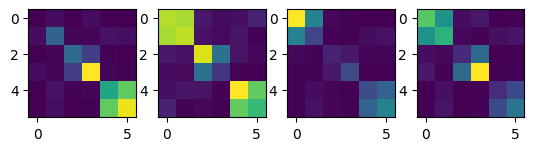

In [4]:
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(np.abs(isd_rf.Sigma_diag[i, :, :]))
plt.show()

# Checks
#isd_rf.th_opt
#isd_rf.th_const
#isd_rf._check_const(isd_rf.blocks_shape, isd_rf.th_const, isd_rf.th_opt)
#isd_rf.var
#isd_rf.var_th

In [4]:
rf = RandomForestRegressor(n_estimators=50, random_state=42, max_features=1.0)
rf.fit(Xtr, Ytr)
preds_rf = rf.predict(Xts)

In [5]:
mean_squared_error(Yts, preds_isd_rf), r2_score(Yts, preds_isd_rf)

(5.049763412196055, -0.29510328595446156)

In [7]:
mean_squared_error(Yts, preds_rf), r2_score(Yts, preds_rf)

(7.570433125255678, -0.9415746870313928)

### References

[1] [**Maximin Effects in Inhomogeneous Large-Scale Data**](https://people.math.ethz.ch/~nicolai/maximin_aos.pdf)
[2] [**Magging: Maximin Aggregation for Inhomogeneous Large-Scale Data**](https://stat.ethz.ch/Manuscripts/buhlmann/ProcIEEE-magging.pdf)
[3] [**Comments on: A random forest guided tour**](https://people.math.ethz.ch/~peterbu/Files/Manuscripts/RFdiscussion-TEST2016.pdf)
[4] [**Invariant Subspace Decomposition**](https://arxiv.org/pdf/2404.09962)